In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
import time
from tabulate import tabulate
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [17]:
PREPROCESSED_EXTRACTED_FEATURES_FILE = 'preprocessed_extracted_features_ent05.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/enterface05/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)
plt.rcParams['figure.dpi'] = 150

In [18]:
df = pd.read_csv(PREPROCESSED_EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df.head()

(1260, 332)


,File,Gender,Emotion,Emotion_Id,spikes_mel_spect,25thpercentile_mel_spect,median_mel_spect,75thpercentile_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,sum_mel_spect,spikes_chroma_stft,25thpercentile_chroma_stft,median_chroma_stft,75thpercentile_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,sum_chroma_stft,spikes_rms,25thpercentile_rms,median_rms,75thpercentile_rms,mean_rms,max_rms,var_rms,std_rms,sum_rms,spikes_spec_cent,25thpercentile_spec_cent,median_spec_cent,75thpercentile_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,sum_spec_cent,spikes_spec_bw,25thpercentile_spec_bw,median_spec_bw,75thpercentile_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,sum_spec_bw,spikes_spec_rolloff,25thpercentile_spec_rolloff,median_spec_rolloff,75thpercentile_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,sum_spec_rolloff,spikes_spec_cont,25thpercentile_spec_cont,median_spec_cont,75thpercentile_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,sum_spec_cont,spikes_tonnetz,25thpercentile_tonnetz,median_tonnetz,75thpercentile_tonnetz,mean_tonnetz,min_tonnetz,max_tonnetz,var_tonnetz,std_tonnetz,sum_tonnetz,spikes_zcr,25thpercentile_zcr,median_zcr,75thpercentile_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,kurtosis_mfcc1,skew_mfcc1,spikes_mfcc1,25thpercentile_mfcc1,median_mfcc1,75thpercentile_mfcc1,mean_mfcc1,min_mfcc1,max_mfcc1,var_mfcc1,std_mfcc1,sum_mfcc1,kurtosis_mfcc2,skew_mfcc2,spikes_mfcc2,25thpercentile_mfcc2,median_mfcc2,75thpercentile_mfcc2,mean_mfcc2,min_mfcc2,max_mfcc2,var_mfcc2,std_mfcc2,sum_mfcc2,kurtosis_mfcc3,skew_mfcc3,spikes_mfcc3,25thpercentile_mfcc3,median_mfcc3,75thpercentile_mfcc3,mean_mfcc3,min_mfcc3,max_mfcc3,var_mfcc3,std_mfcc3,sum_mfcc3,kurtosis_mfcc4,skew_mfcc4,spikes_mfcc4,25thpercentile_mfcc4,median_mfcc4,75thpercentile_mfcc4,mean_mfcc4,min_mfcc4,max_mfcc4,var_mfcc4,std_mfcc4,sum_mfcc4,kurtosis_mfcc5,skew_mfcc5,spikes_mfcc5,25thpercentile_mfcc5,median_mfcc5,75thpercentile_mfcc5,mean_mfcc5,min_mfcc5,max_mfcc5,var_mfcc5,std_mfcc5,sum_mfcc5,kurtosis_mfcc6,skew_mfcc6,spikes_mfcc6,25thpercentile_mfcc6,median_mfcc6,75thpercentile_mfcc6,mean_mfcc6,min_mfcc6,max_mfcc6,var_mfcc6,std_mfcc6,sum_mfcc6,kurtosis_mfcc7,skew_mfcc7,spikes_mfcc7,25thpercentile_mfcc7,median_mfcc7,75thpercentile_mfcc7,mean_mfcc7,min_mfcc7,max_mfcc7,var_mfcc7,std_mfcc7,sum_mfcc7,kurtosis_mfcc8,skew_mfcc8,spikes_mfcc8,25thpercentile_mfcc8,median_mfcc8,75thpercentile_mfcc8,mean_mfcc8,min_mfcc8,max_mfcc8,var_mfcc8,std_mfcc8,sum_mfcc8,kurtosis_mfcc9,skew_mfcc9,spikes_mfcc9,25thpercentile_mfcc9,median_mfcc9,75thpercentile_mfcc9,mean_mfcc9,min_mfcc9,max_mfcc9,var_mfcc9,std_mfcc9,sum_mfcc9,kurtosis_mfcc10,skew_mfcc10,spikes_mfcc10,25thpercentile_mfcc10,median_mfcc10,75thpercentile_mfcc10,mean_mfcc10,min_mfcc10,max_mfcc10,var_mfcc10,std_mfcc10,sum_mfcc10,kurtosis_mfcc11,skew_mfcc11,spikes_mfcc11,25thpercentile_mfcc11,median_mfcc11,75thpercentile_mfcc11,mean_mfcc11,min_mfcc11,max_mfcc11,var_mfcc11,std_mfcc11,sum_mfcc11,kurtosis_mfcc12,skew_mfcc12,spikes_mfcc12,25thpercentile_mfcc12,median_mfcc12,75thpercentile_mfcc12,mean_mfcc12,min_mfcc12,max_mfcc12,var_mfcc12,std_mfcc12,sum_mfcc12,kurtosis_mfcc13,skew_mfcc13,spikes_mfcc13,25thpercentile_mfcc13,median_mfcc13,75thpercentile_mfcc13,mean_mfcc13,min_mfcc13,max_mfcc13,var_mfcc13,std_mfcc13,sum_mfcc13,kurtosis_mfcc14,skew_mfcc14,spikes_mfcc14,25thpercentile_mfcc14,median_mfcc14,75thpercentile_mfcc14,mean_mfcc14,min_mfcc14,max_mfcc14,var_mfcc14,std_mfcc14,sum_mfcc14,kurtosis_mfcc15,skew_mfcc15,spikes_mfcc15,25thpercentile_mfcc15,median_mfcc15,75thpercentile_mfcc15,mean_mfcc15,min_mfcc15,max_mfcc15,var_mfcc15,std_mfcc15,sum_mfcc15,kurtosis_mfcc16,skew_mfcc16,spikes_mfcc16,25thpercentile_mfcc16,median_mfcc16,75thpercentile_mfcc16,mean_mfcc16,min_mfcc16,max_mfcc16,var_mfcc16,std_mfcc16,sum_mfcc16,kurtosis_mfcc17,skew_mfcc17,spike

In [19]:
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
disgust,1,210
fear,2,210
happiness,3,210
sadness,4,210
surprise,5,210


In [20]:
df = df[df['Emotion'].isin({'anger', 'happiness', 'sadness', 'surprise'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 4, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 3
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

,,Emotion
,,count
Emotion,Emotion_Id,
anger,0,210
happiness,1,210
sadness,2,210
surprise,3,210


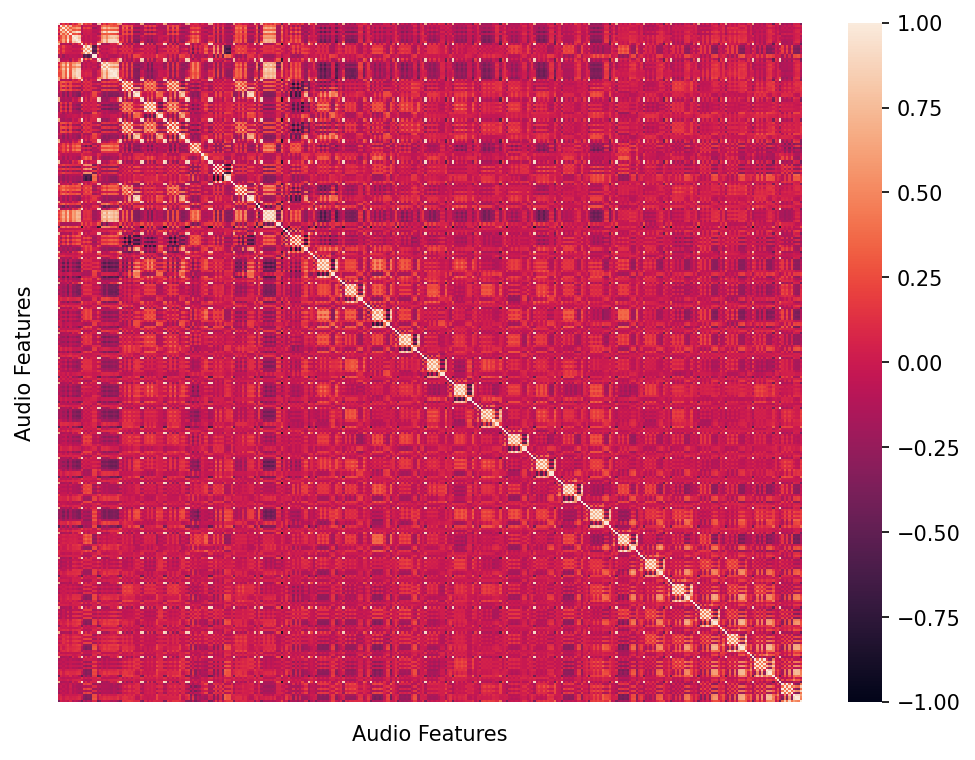

In [21]:
df_corr = df.iloc[:,4:].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(df_corr, annot=False, fmt=".1f", vmin=-1, vmax=1)
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
# plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [22]:
def hight_corr_feat_elimination(df_corr, high_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > high_corr\
            and ((pair[0][1], pair[0][0]), abs(pair[1])) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), abs(pair[1])))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > high_corr and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [23]:
df_corr = df.iloc[:,4:].corr()
eliminated_feats = hight_corr_feat_elimination(df_corr, 0.55)
print(len(eliminated_feats))
print(eliminated_feats)

230
{'std_mfcc10', 'std_mfcc12', 'var_mfcc14', '25thpercentile_mfcc12', 'median_rms', 'std_mfcc8', 'max_spec_bw', 'median_mfcc6', '25thpercentile_mel_spect', 'min_mfcc5', 'mean_mfcc11', 'min_mfcc20', 'mean_mfcc15', 'spikes_mfcc13', 'spikes_mfcc15', 'spikes_mel_spect', 'spikes_spec_cont', '25thpercentile_mfcc7', 'min_mfcc1', 'sum_zcr', '75thpercentile_mfcc1', 'mean_mfcc19', 'var_chroma_stft', 'max_rms', 'mean_spec_rolloff', 'median_mfcc13', 'mean_mel_spect', 'mean_rms', 'sum_mfcc8', '25thpercentile_mfcc8', 'min_mfcc14', '25thpercentile_mfcc15', 'spikes_spec_cent', 'sum_mfcc6', 'spikes_spec_bw', 'max_mel_spect', 'min_mfcc4', '75thpercentile_zcr', 'spikes_mfcc18', '25thpercentile_mfcc2', 'spikes_mfcc4', '25thpercentile_mfcc11', 'std_mel_spect', 'std_mfcc16', 'min_mfcc11', '25thpercentile_mfcc10', 'spikes_chroma_stft', 'median_spec_cont', '25thpercentile_mfcc3', 'spikes_mfcc9', 'mean_spec_cent', 'mean_chroma_stft', 'spikes_mfcc17', 'min_mfcc15', '25thpercentile_mfcc14', 'std_mfcc2', 'media

In [24]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-4
print(f"Number of features after high correlation elimination: {num_features}")
print(set(df.columns[4:]))

Number of features after high correlation elimination: 97
{'max_mfcc14', '75thpercentile_mfcc17', 'median_mfcc17', 'max_mfcc11', 'kurtosis_mfcc12', 'var_mfcc12', 'max_mfcc9', 'min_zcr', 'skew_mfcc10', 'kurtosis_mfcc4', 'var_spec_cont', 'kurtosis_mfcc6', 'var_spec_bw', 'mean_tonnetz', 'skew_mfcc16', 'kurtosis_mfcc15', 'std_mfcc1', 'skew_mfcc6', 'median_spec_cent', 'median_mfcc5', 'kurtosis_mfcc20', 'median_mfcc20', 'median_mfcc4', 'var_mfcc3', 'skew_mfcc15', '75thpercentile_tonnetz', 'max_mfcc10', 'skew_mfcc3', '75thpercentile_mfcc13', 'kurtosis_mfcc10', 'skew_mfcc4', 'median_mfcc18', 'median_mfcc19', 'skew_mfcc17', 'skew_mfcc14', 'var_mfcc10', 'var_mfcc4', 'kurtosis_mfcc2', 'median_mfcc14', '75thpercentile_spec_bw', 'kurtosis_mfcc13', 'kurtosis_mfcc7', '75thpercentile_mel_spect', 'var_mfcc13', 'skew_mfcc12', 'var_mel_spect', 'kurtosis_mfcc16', '75thpercentile_mfcc18', 'max_spec_cont', 'median_mfcc15', '75thpercentile_mfcc19', 'max_mfcc6', 'kurtosis_mfcc8', '75thpercentile_mfcc9', 'mean

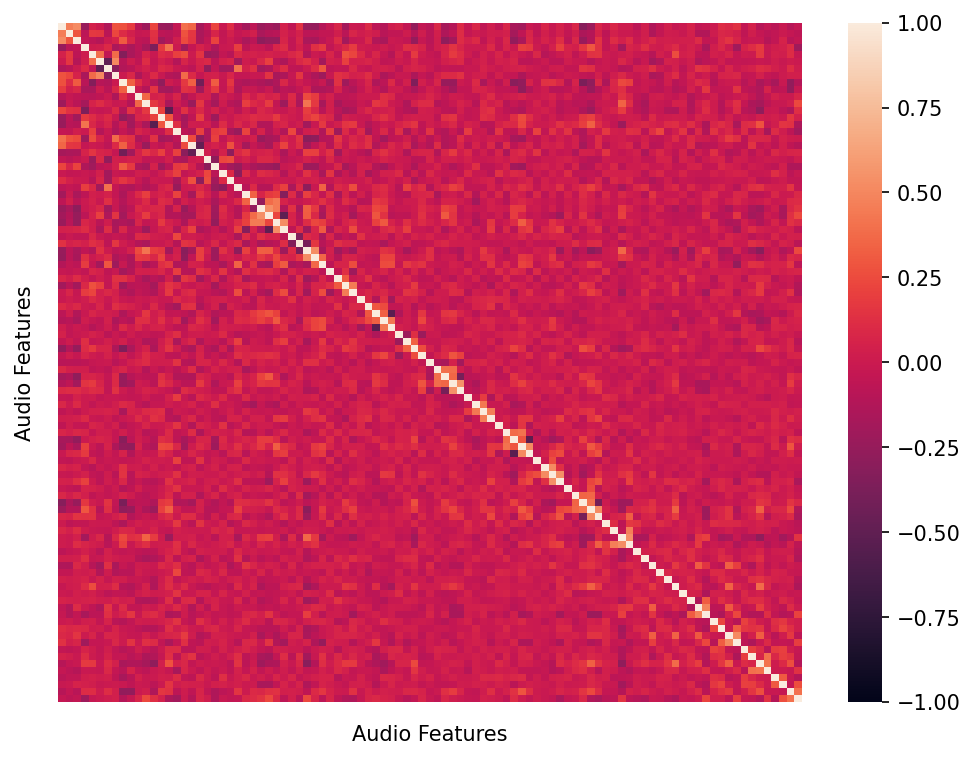

In [25]:
plt.figure(figsize=(8, 6))
df_corr = df.iloc[:,4:].corr()
g = sns.heatmap(df_corr, annot=False, fmt=".2f", vmin=-1, vmax=1)
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [26]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

In [214]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        start_time = time.time()
        scores = cross_val_score(clf, data, labels, cv=5)
        total_time = time.time() - start_time

        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score, total_time)
    
    return clfs_scores

In [215]:
%%capture
clfs = [
    DecisionTree(random_state=1),
    ExtraTree(random_state=1),
    RandomForest(random_state=1, n_estimators=200),
    AdaBoostClassifier(random_state=1, n_estimators=200),
    svm.SVC(decision_function_shape='ovo', random_state=1),
    ExtraTrees(random_state=1, n_estimators=200),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1),
    MLPClassifier(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [216]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers = 'keys'
))

print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers='keys', tablefmt="latex_booktabs"
))

Classifiers Ordered by Highest Mean Accuracy:
                          Mean Accuracy    Std Accuracy    CV Time
----------------------  ---------------  --------------  ---------
RidgeClassifier                0.652381       0.0239874  0.0380661
ExtraTreesClassifier           0.640476       0.0482987  1.78998
RandomForestClassifier         0.629762       0.02751    4.52994
XGBClassifier                  0.619048       0.0370772  2.45612
AdaBoostClassifier             0.584524       0.0253658  9.01879
DecisionTreeClassifier         0.408333       0.0421906  0.227976
ExtraTreeClassifier            0.364286       0.0447657  0.0266218
SVC                            0.329762       0.0458913  0.20288
MLPClassifier                  0.30119        0.0348303  0.716993
Classifiers Ordered by Highest Mean Accuracy:
\begin{tabular}{lrrr}
\toprule
                        &   Mean Accuracy &   Std Accuracy &   CV Time \\
\midrule
 RidgeClassifier        &        0.652381 &      0.0239874 & 0.038066

In [28]:
feat_elim = {}
df_train = data.copy()
for i in tqdm(range(num_features-1, 0, -1)):
    sfs1 = sfs(Ridge(random_state=1), k_features=i, forward=False, cv=5, verbose=0, n_jobs=-1)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

100%|██████████| 96/96 [00:16<00:00,  5.92it/s]


In [29]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('pre_feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                            Accuracy
------------------------  ----------
skew_mfcc8                  0.663095
max_mfcc10                  0.666667
kurtosis_mfcc11             0.669048
75thpercentile_mfcc17       0.672619
kurtosis_mfcc14             0.678571
skew_mfcc4                  0.686905
kurtosis_mfcc17             0.688095
kurtosis_mfcc13             0.691667
mean_tonnetz                0.692857
75thpercentile_mel_spect    0.692857


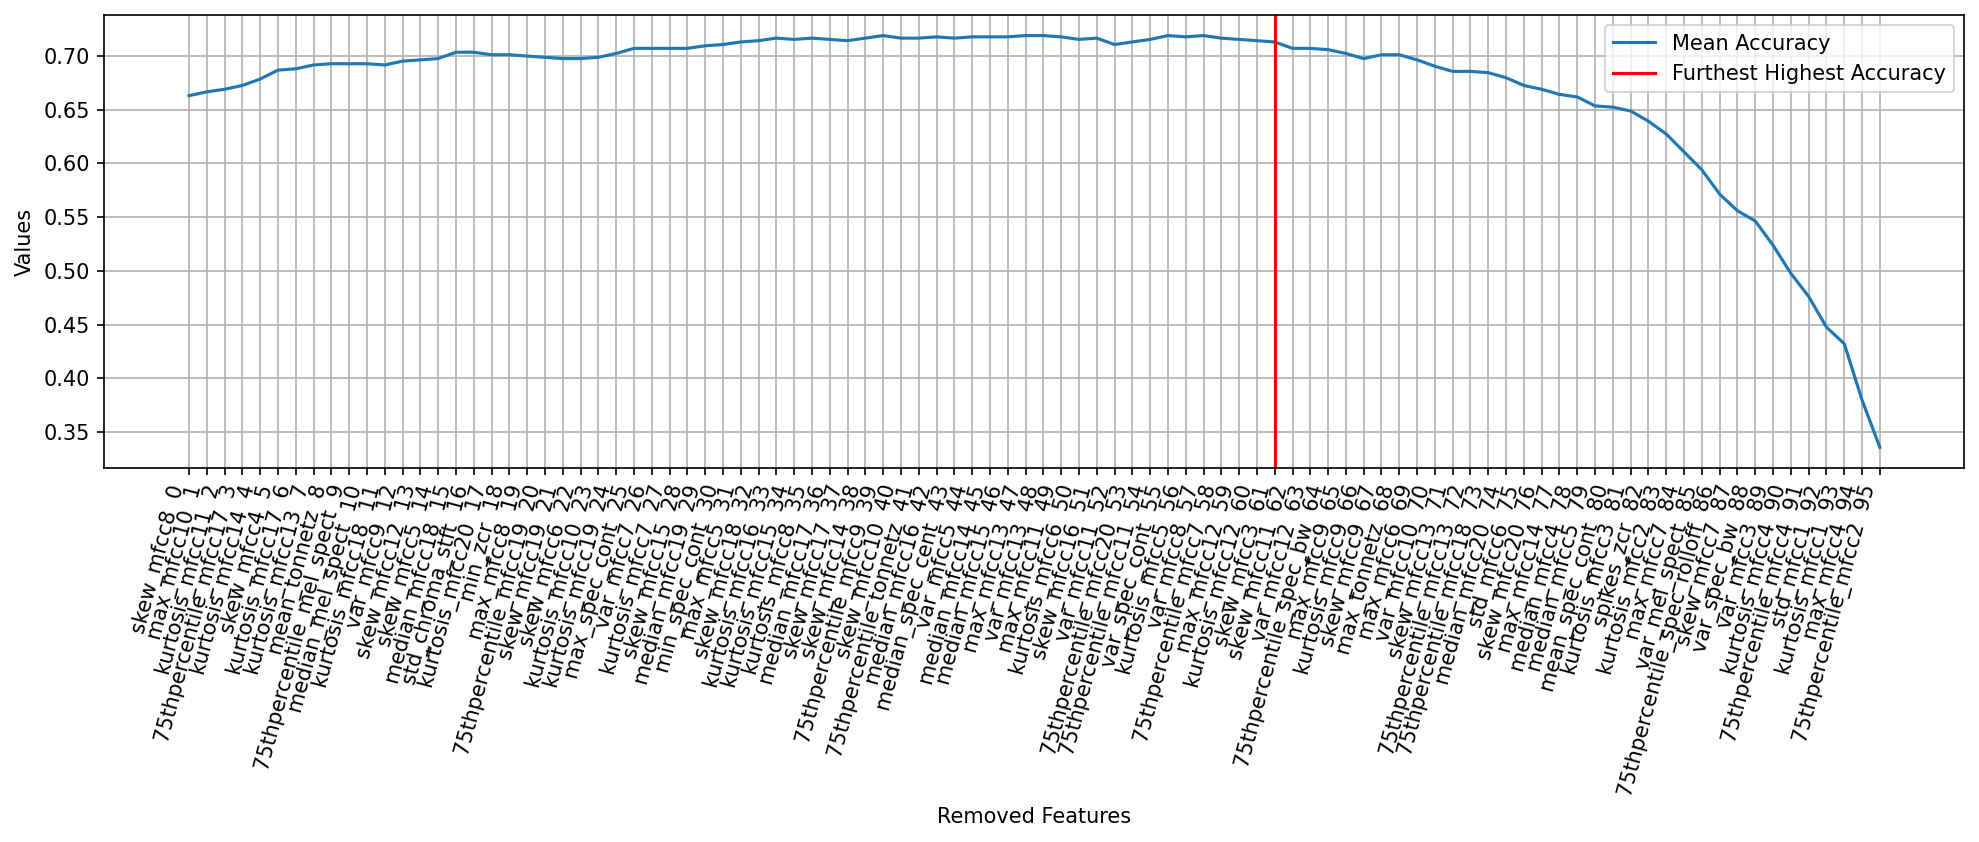

In [30]:
feat_elim_df = pd.read_csv("pre_feat_elim.csv", index_col=0)
max_acc = 0
max_feat = None
for feat, columns in feat_elim_df.iterrows():
    if columns["Accuracy"] >= max_acc*.995:
        max_acc =  columns["Accuracy"]
        max_feat = feat
elim_feats = []
for feat, columns in feat_elim_df.iterrows():
    elim_feats.append(feat)
    if feat == max_feat:
        break
idx = len(elim_feats) - 1
fig = plt.figure(figsize=(16,4))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
ax.axvline(x = idx, color = 'r', label="Furthest Highest Accuracy")
plt.legend()

In [31]:
print('Backward Feature Elimination with Propagation"\n')
print(f"Number of Eliminated Features Using:\n\t-Accuracy as the Decider Metric: {len(elim_feats)}")

Backward Feature Elimination with Propagation"

Number of Eliminated Features Using:
	-Accuracy as the Decider Metric: 62


In [32]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")
print(set(features))

Number of Features After Eliminating Common Features: 35
{'spikes_zcr', 'var_mel_spect', 'median_mfcc5', 'max_mfcc14', '75thpercentile_mfcc18', 'median_mfcc20', 'median_mfcc4', 'var_mfcc3', '75thpercentile_mfcc13', 'max_mfcc6', 'max_mfcc4', '75thpercentile_mfcc2', 'mean_spec_cont', 'var_mfcc12', 'skew_mfcc13', 'kurtosis_mfcc3', '75thpercentile_mfcc4', '75thpercentile_spec_rolloff', 'std_mfcc6', 'skew_mfcc7', 'max_mfcc9', 'var_mfcc4', 'var_mfcc10', 'skew_mfcc9', 'skew_mfcc11', 'max_mfcc7', 'kurtosis_mfcc2', 'kurtosis_mfcc4', 'kurtosis_mfcc9', '75thpercentile_spec_bw', 'var_spec_bw', 'kurtosis_mfcc1', 'max_tonnetz', 'skew_mfcc20', 'std_mfcc1'}


In [33]:
def get_tick_labels(val, aro):
    if val and aro:
        return [
            '(0, 0) - sadness',
            '(0, 1) - anger',
            '(1, 1) - happiness, surprise'
        ]
    elif val:
        return [
            '0 - Low Valence',
            '1 - High Valence'
        ]
    elif aro:
        return [
            '0 - Low Arousal',
            '1 - High Arousal'
        ]
    else:
        return [
            '0 - anger',
            '1 - happiness',
            '2 - sadness',
            '3 - surprise'
        ]

In [34]:
'''
calculate multi-class classification and return related evaluation metrics
'''
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming_loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews_corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero_one_loss: ", metrics.zero_one_loss(labels, y_pred))

In [38]:
def plot_cm_predictions(clf, input_data, labels, cv=5, val=False, aro=False, scoring='accuracy', draw_corr_matrix=True, one_hot_encoding=pd.DataFrame()):
    if one_hot_encoding.empty:
        y_pred = cross_val_predict(clf, input_data, labels, cv=cv)
    else:
        y_pred = cross_val_predict(clf, input_data, one_hot_encoding, cv=cv)
        y_pred = y_pred.argmax(1)
        
    ticks = get_tick_labels(val, aro)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred, target_names=ticks))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred, normalize='all')
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0) 
        plt.show()

In [39]:
df = pd.read_csv(PREPROCESSED_EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df = df[df['Emotion'].isin({'anger', 'happiness', 'sadness', 'surprise'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 4, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 3
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")
df[df.columns[4:]].shape

(840, 327)

accuracy:  0.6404761904761904
f1 score macro:  0.639452346429781
f1 score micro:  0.6404761904761904
precision score:  0.6389964741607872
recall score:  0.6404761904761904
hamming_loss:  0.3595238095238095
matthews_corrcoef:  0.5207894483666297
zero_one_loss:  0.3595238095238096
               precision    recall  f1-score   support

    0 - anger       0.70      0.70      0.70       210
1 - happiness       0.57      0.58      0.57       210
  2 - sadness       0.69      0.73      0.71       210
 3 - surprise       0.59      0.55      0.57       210

     accuracy                           0.64       840
    macro avg       0.64      0.64      0.64       840
 weighted avg       0.64      0.64      0.64       840



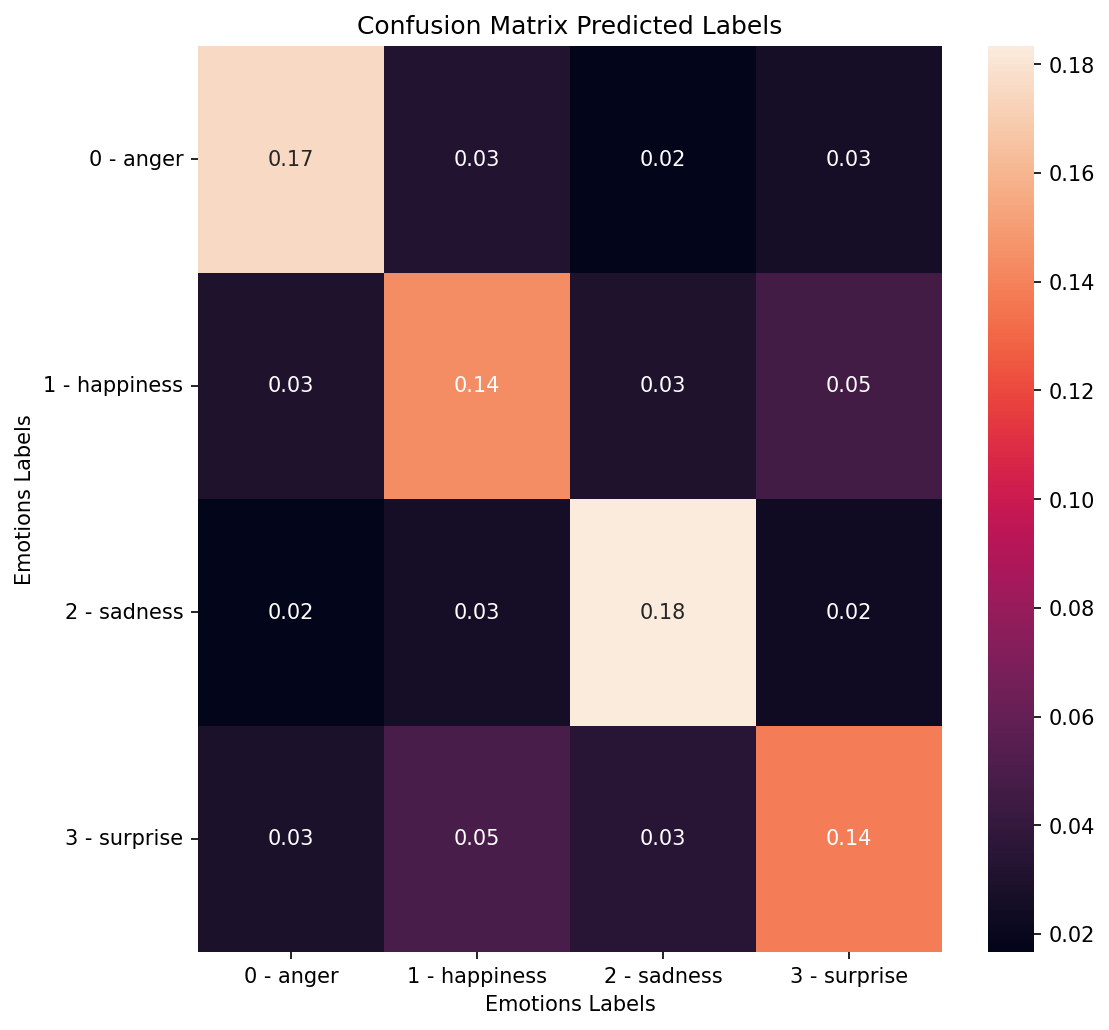

In [40]:
plot_cm_predictions(Ridge(random_state=1), df[df.columns[4:]].values, labels)

In [41]:
data.shape

(840, 97)

accuracy:  0.6523809523809524
f1 score macro:  0.6489294360785213
f1 score micro:  0.6523809523809524
precision score:  0.6492961262283838
recall score:  0.6523809523809524
hamming_loss:  0.3476190476190476
matthews_corrcoef:  0.5375368640258602
zero_one_loss:  0.3476190476190476
               precision    recall  f1-score   support

    0 - anger       0.69      0.75      0.72       210
1 - happiness       0.62      0.61      0.61       210
  2 - sadness       0.68      0.74      0.71       210
 3 - surprise       0.61      0.51      0.56       210

     accuracy                           0.65       840
    macro avg       0.65      0.65      0.65       840
 weighted avg       0.65      0.65      0.65       840



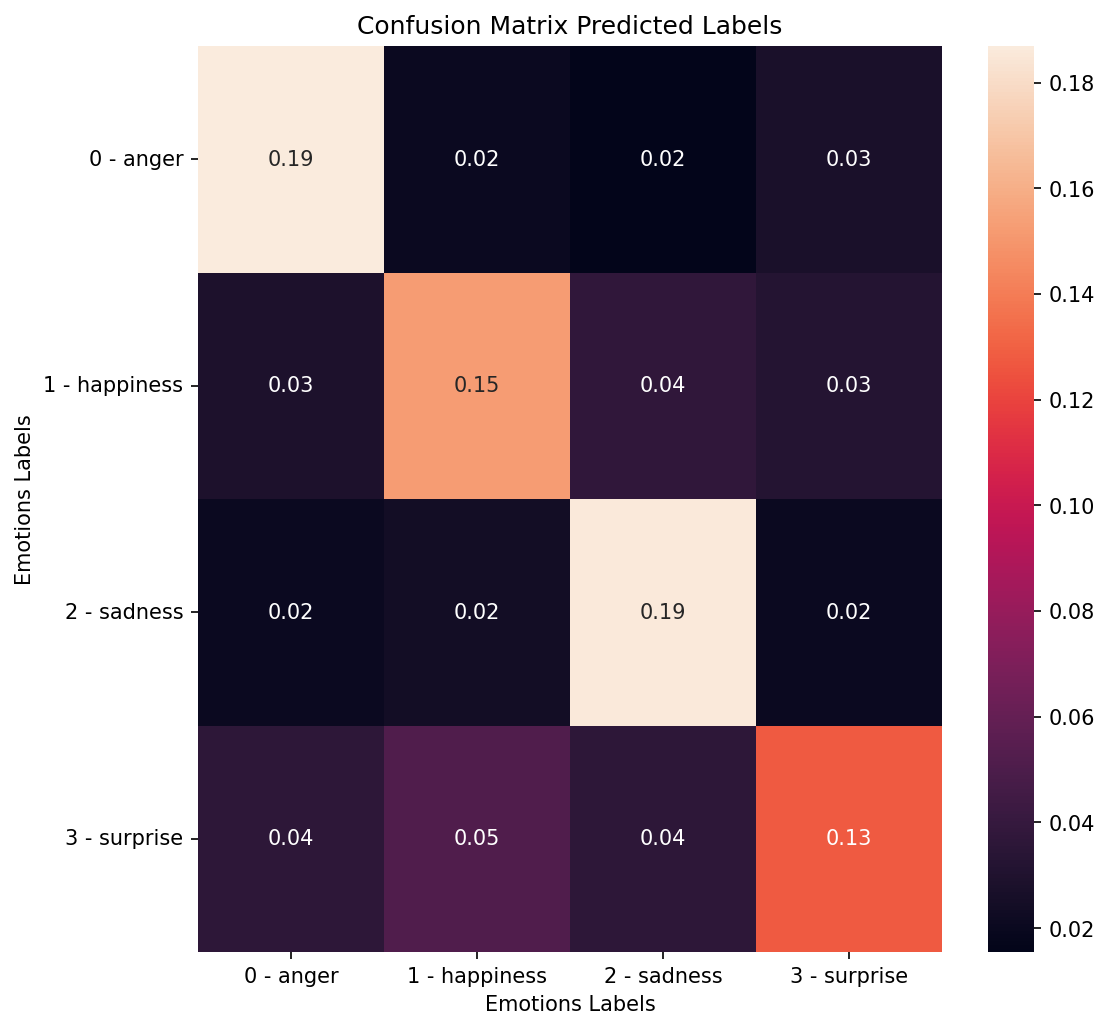

In [42]:
plot_cm_predictions(Ridge(random_state=1), data.values, labels)

In [43]:
data_elim_feats.shape

(840, 35)

accuracy:  0.7130952380952381
f1 score macro:  0.7104980456089766
f1 score micro:  0.7130952380952381
precision score:  0.7118410151554434
recall score:  0.713095238095238
hamming_loss:  0.2869047619047619
matthews_corrcoef:  0.6185752720888392
zero_one_loss:  0.2869047619047619
               precision    recall  f1-score   support

    0 - anger       0.75      0.80      0.77       210
1 - happiness       0.70      0.70      0.70       210
  2 - sadness       0.70      0.78      0.74       210
 3 - surprise       0.69      0.58      0.63       210

     accuracy                           0.71       840
    macro avg       0.71      0.71      0.71       840
 weighted avg       0.71      0.71      0.71       840



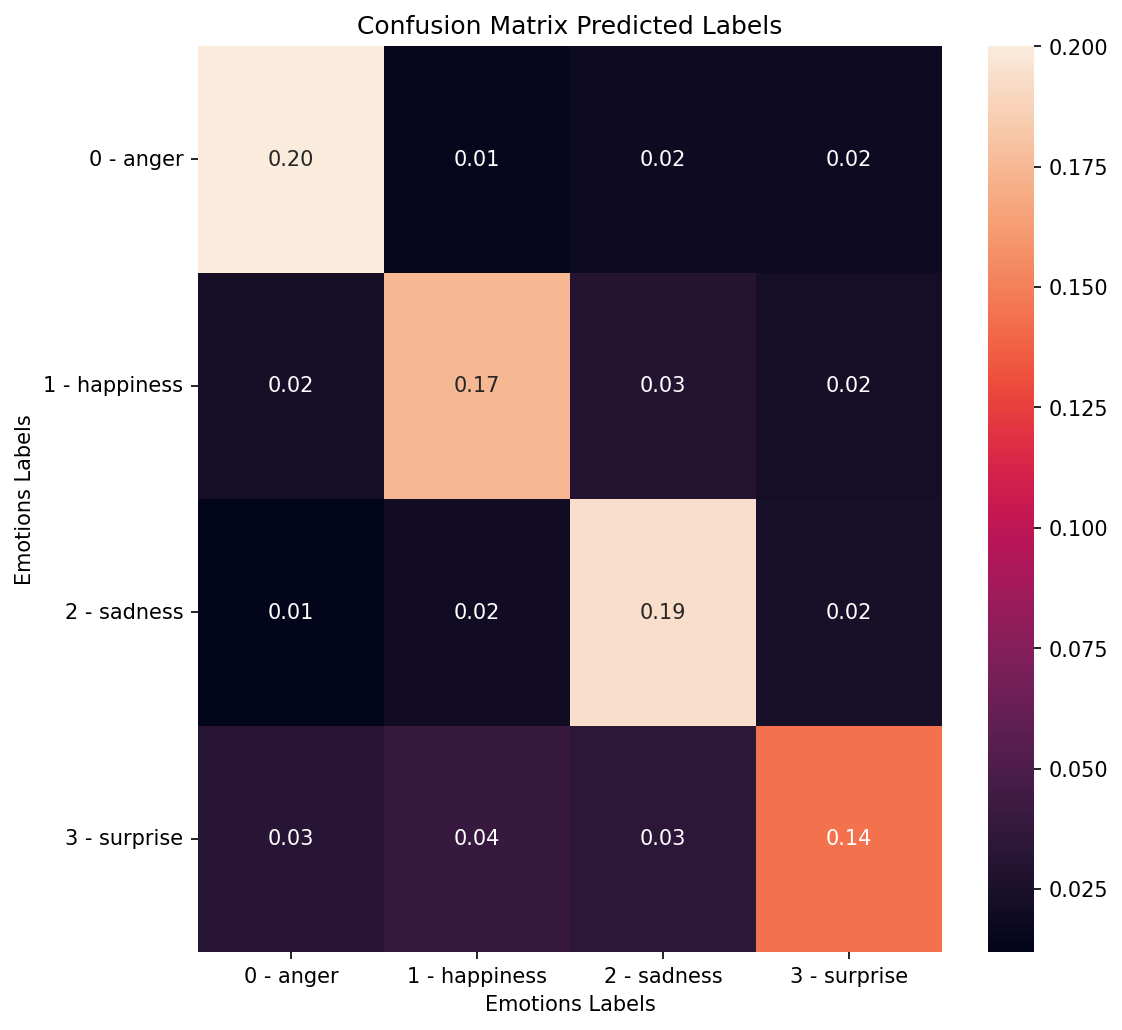

In [44]:
plot_cm_predictions(Ridge(random_state=1), data_elim_feats.values, labels)